In [1]:
# DATA PREPARATION AND CONFIGURATION

import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import os
import gc # Import the garbage collector

print("--- Phase 1: Starting Data Preparation ---")

# --- Configuration (with memory optimizations) ---
BASE_INPUT_PATH = '/kaggle/input/downsized-data'
IMAGE_DIR = os.path.join(BASE_INPUT_PATH, 'nih_images_resized_256/')
CSV_PATH = os.path.join(BASE_INPUT_PATH, 'Data_Entry_2017_stratified_downsized.csv')

IMG_SIZE = 224
BATCH_SIZE = 16 # Reduced batch size to lower memory per step
SHUFFLE_BUFFER_SIZE = 1024 # Reduced shuffle buffer to save RAM
AUTOTUNE = tf.data.AUTOTUNE

# --- Load and Prepare Labels ---
df = pd.read_csv(CSV_PATH)
final_14_labels = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
    'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule',
    'Pneumonia', 'Pneumothorax', 'No Finding'
]
for label in final_14_labels:
    clean_label_to_find = label.replace('_', ' ').lower()
    df[label] = df['Finding Labels'].str.lower().apply(
        lambda finding_string: 1 if clean_label_to_find in str(finding_string) else 0
    )
df['image_path'] = df['Image Index'].apply(lambda x: os.path.join(IMAGE_DIR, x))

# --- Train-Validation Split ---
train_df, val_df = train_test_split(
    df, test_size=0.15, random_state=42
)
print(f"Training set size: {len(train_df)} images")
print(f"Validation set size: {len(val_df)} images")

# --- Preprocessing and Augmentation Functions ---
def parse_function(image_path, labels):
    img_raw = tf.io.read_file(image_path)
    img = tf.io.decode_png(img_raw, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.grayscale_to_rgb(img) # Convert to 3 channels for MobileNetV2
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    return img, labels

def augment_function(image, labels):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.05)
    return image, labels

# --- Build tf.data Pipelines ---
def create_dataset(dataframe):
    image_paths = dataframe['image_path'].values
    labels = dataframe[final_14_labels].values.astype(np.float32)
    ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    ds = ds.map(parse_function, num_parallel_calls=AUTOTUNE)
    return ds

train_dataset = (
    create_dataset(train_df)
    .shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
    .map(augment_function, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTOTUNE)
)
validation_dataset = (
    create_dataset(val_df)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTOTUNE)
)

# --- Clean up DataFrames to free RAM before training ---
print("Deleting DataFrames to free up memory...")
del df, train_df, val_df
gc.collect()

print("\nComplete: `train_dataset` and `validation_dataset` are ready. ---")

2025-06-23 20:42:29.423534: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750711349.450130     120 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750711349.457936     120 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


--- Phase 1: Starting Data Preparation ---
Training set size: 48706 images
Validation set size: 8596 images


2025-06-23 20:42:34.339436: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Deleting DataFrames to free up memory...

Complete: `train_dataset` and `validation_dataset` are ready. ---


In [2]:
# MODEL DEFINITION AND TRAINING
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# --- Define the Model Architecture ---
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3) 
)
base_model.trainable = False

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(len(final_14_labels), activation='sigmoid')(x)
model = Model(inputs, outputs)

# --- Compile the Model ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc_roc', multi_label=True)]
)
model.summary()

# --- Define Callbacks ---
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_auc_roc',
    mode='max',
    save_best_only=True,
    verbose=1
)
early_stopping_callback = EarlyStopping(
    monitor='val_auc_roc',
    mode='max',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

# --- Train the Model ---
print("\n--- Starting Model Training ---")
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=5,
    callbacks=[checkpoint_callback, early_stopping_callback]
)
print("\n--- Model Training Complete ---")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 14)                  │          17,934 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,275,918 (8.68 MB)

 Trainable params: 17,934 (70.05 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


--- Starting Model Training ---
Epoch 1/5
3044/3045 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - auc_roc: 0.6246 - loss: 0.2408
Epoch 1: val_auc_roc improved from -inf to 0.71618, saving model to best_model.keras
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 1134s 369ms/step - auc_roc: 0.6246 - loss: 0.2408 - val_auc_roc: 0.7162 - val_loss: 0.2243
Epoch 2/5
3044/3045 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - auc_roc: 0.6962 - loss: 0.2233
Epoch 2: val_auc_roc improved from 0.71618 to 0.72258, saving model to best_model.keras
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 1166s 382ms/step - auc_roc: 0.6962 - loss: 0.2233 - val_auc_roc: 0.7226 - val_loss: 0.2274
Epoch 3/5
3044/3045 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - auc_roc: 0.7033 - loss: 0.2227
Epoch 3: val_auc_roc improved from 0.72258 to 0.72459, saving model to best_model.keras
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 1135s 372ms/step - auc_roc: 0.7033 - loss: 0.2227 - val_auc_roc: 0.7246 - val_loss: 0.2262
Epoch 4/5
3044/3045 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - auc_roc: 0.7113 - l

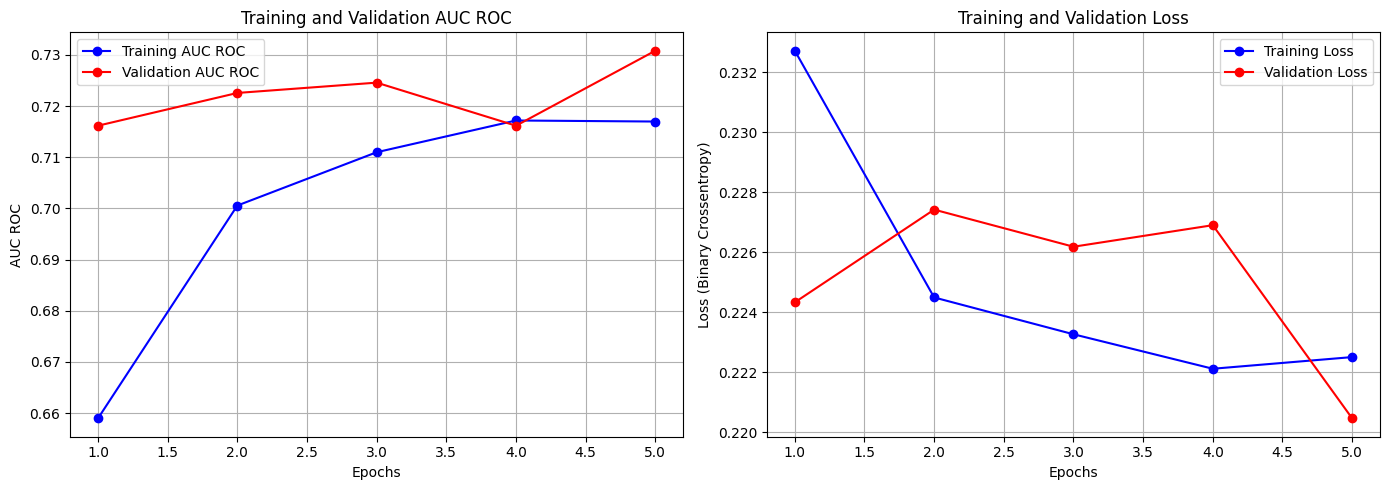

In [ ]:

import matplotlib.pyplot as plt

history_dict = history.history
train_auc = history_dict['auc_roc']
val_auc = history_dict['val_auc_roc']
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']


epochs_ran = range(1, len(train_auc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_ran, train_auc, 'bo-', label='Training AUC ROC')
plt.plot(epochs_ran, val_auc, 'ro-', label='Validation AUC ROC')
plt.title('Training and Validation AUC ROC')
plt.xlabel('Epochs')
plt.ylabel('AUC ROC')
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(epochs_ran, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs_ran, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Binary Crossentropy)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()